In [ ]:
%%capture
!pip install numpy pandas matplotlib torch
# TODO: switch to use pypi package gretel-synthetics once released
!pip install git+https://github.com/gretelai/gretel-synthetics.git


In [2]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from gretel_synthetics.timeseries_dgan.dgan import DGAN
from gretel_synthetics.timeseries_dgan.config import DGANConfig, OutputType, Normalization

In [3]:
S3_BASE_URL = "https://gretel-public-website.s3.us-west-2.amazonaws.com/datasets/wiki-web-traffic-data/"

wwt = pd.read_csv(S3_BASE_URL + "wikipedia-web-traffic-training.csv", index_col=0)
wwt.drop(columns=["domain_name", "access_name", "agent_name"], inplace=True)
assert wwt.shape[1] == 553
wwt.head()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,domain,access,agent
0,-0.333795,-0.319665,-0.314942,-0.308651,-0.291297,-0.312655,-0.309529,-0.306918,-0.310413,-0.317752,...,-0.269336,-0.277937,-0.258538,-0.235855,-0.241672,-0.254042,-0.266611,3,0,0
1,-0.692347,-0.699509,-0.744500,-0.769260,-0.744500,-0.846174,-0.784077,-0.724269,-0.699509,-0.769260,...,-0.692347,-0.673278,-0.667587,-0.699509,-0.707164,-0.769260,-0.707164,6,1,0
2,-0.291111,-0.298633,-0.346250,-0.431433,-0.404062,-0.324597,-0.317989,-0.342335,-0.344124,-0.390935,...,-0.638474,-0.587933,-0.553338,-0.528577,-0.531794,-0.563716,-0.596365,3,0,0
3,-0.565913,-0.565913,-0.570443,-0.570443,-0.596365,-0.575165,-0.605490,-0.570443,-0.518001,-0.580098,...,-0.630251,-0.608707,-0.572779,-0.590673,-0.559447,-0.582649,-0.561561,2,0,1
4,-0.430120,-0.547547,-0.608707,-0.538521,-0.505735,-0.449311,-0.408269,-0.395140,-0.390022,-0.418952,...,-0.513760,-0.542044,-0.512382,-0.518001,-0.503184,-0.519452,-0.540268,2,0,1


In [3]:
# Extract numpy arrays for charts
wwt_attributes = wwt[["domain", "access", "agent"]].to_numpy()
print(wwt_attributes.shape)
wwt_features = np.expand_dims(wwt.iloc[:, 0:550].to_numpy(), axis=-1)
print(wwt_features.shape)

(50000, 3)
(50000, 550, 1)


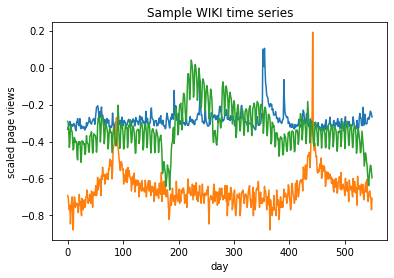

In [25]:
# Plot a few time series
for index in [0,1,2]:
    plt.plot(wwt_features[index,:,0])

plt.xlabel("day")
plt.ylabel("scaled page views")
plt.title("Sample WIKI time series")
plt.show()

In [5]:
# Autocorrelation computation
# From https://github.com/fjxmlzn/DoppelGANger/issues/20#issuecomment-858234890
EPS = 1e-8

def autocorr(X, Y):
    Xm = torch.mean(X, 1).unsqueeze(1)
    Ym = torch.mean(Y, 1).unsqueeze(1)
    r_num = torch.sum((X - Xm) * (Y - Ym), 1)
    r_den = torch.sqrt(torch.sum((X - Xm)**2, 1) * torch.sum((Y - Ym)**2, 1))

    r_num[r_num == 0] = EPS
    r_den[r_den == 0] = EPS

    r = r_num / r_den
    r[r > 1] = 0
    r[r < -1] = 0

    return r


def get_autocorr(feature):
    feature = torch.from_numpy(feature)
    feature_length = feature.shape[1]
    autocorr_vec = torch.Tensor(feature_length - 2)

    for j in range(1, feature_length - 1):
        autocorr_vec[j - 1] = torch.mean(autocorr(feature[:, :-j],
                                                  feature[:, j:]))

    return autocorr_vec.cpu().detach().numpy()

# Train fast model
Modified params for larger batch_size to better utilize the GPU.

Specific changes from params used in https://github.com/fjxmlzn/DoppelGANger
* batch_size=1000 (was 100)
* learning_rate=1e-4 (1e-3), changed for generator and discriminators



In [6]:
# Train DGAN model

config1 = DGANConfig(
    max_sequence_len=wwt.shape[1] - 3,
    sample_len=10,
    use_attribute_discriminator=True,
    gradient_penalty_coef=10.0,
    attribute_gradient_penalty_coef=10.0,
    generator_learning_rate=1e-4,
    discriminator_learning_rate=1e-4,
    attribute_discriminator_learning_rate=1e-4,
    attribute_loss_coef=1.0,
    apply_feature_scaling=False,  # features are already scaled to [-1,1]
    apply_example_scaling=True,
    normalization=Normalization.MINUSONE_ONE,
    batch_size=1000,
    epochs=400,
)

wwt_model1 = DGAN(config=config1)

start_time = time.time()
wwt_model1.train_dataframe(
    df=wwt,
    df_attribute_columns=["domain", "access", "agent"],
    attribute_types=[OutputType.DISCRETE] * 3,
    feature_types=[OutputType.CONTINUOUS],
)

# Generate data

synthetic1 = wwt_model1.generate_dataframe(50000)

synthetic1.head()

end_time = time.time()
print("Elapsed time: {} seconds".format(end_time - start_time))

2022-05-12 17:20:34,237 : MainThread : INFO : epoch: 0
2022-05-12 17:20:36,900 : MainThread : INFO : epoch: 1
2022-05-12 17:20:39,432 : MainThread : INFO : epoch: 2
2022-05-12 17:20:41,875 : MainThread : INFO : epoch: 3
2022-05-12 17:20:44,369 : MainThread : INFO : epoch: 4
2022-05-12 17:20:46,869 : MainThread : INFO : epoch: 5
2022-05-12 17:20:49,323 : MainThread : INFO : epoch: 6
2022-05-12 17:20:51,833 : MainThread : INFO : epoch: 7
2022-05-12 17:20:54,297 : MainThread : INFO : epoch: 8
2022-05-12 17:20:56,815 : MainThread : INFO : epoch: 9
2022-05-12 17:20:59,341 : MainThread : INFO : epoch: 10
2022-05-12 17:21:01,801 : MainThread : INFO : epoch: 11
2022-05-12 17:21:04,346 : MainThread : INFO : epoch: 12
2022-05-12 17:21:06,819 : MainThread : INFO : epoch: 13
2022-05-12 17:21:09,340 : MainThread : INFO : epoch: 14
2022-05-12 17:21:11,877 : MainThread : INFO : epoch: 15
2022-05-12 17:21:14,358 : MainThread : INFO : epoch: 16
2022-05-12 17:21:16,908 : MainThread : INFO : epoch: 17
20

2022-05-12 17:26:46,006 : MainThread : INFO : epoch: 146
2022-05-12 17:26:48,566 : MainThread : INFO : epoch: 147
2022-05-12 17:26:51,085 : MainThread : INFO : epoch: 148
2022-05-12 17:26:53,650 : MainThread : INFO : epoch: 149
2022-05-12 17:26:56,166 : MainThread : INFO : epoch: 150
2022-05-12 17:26:58,730 : MainThread : INFO : epoch: 151
2022-05-12 17:27:01,297 : MainThread : INFO : epoch: 152
2022-05-12 17:27:03,822 : MainThread : INFO : epoch: 153
2022-05-12 17:27:06,386 : MainThread : INFO : epoch: 154
2022-05-12 17:27:08,957 : MainThread : INFO : epoch: 155
2022-05-12 17:27:11,469 : MainThread : INFO : epoch: 156
2022-05-12 17:27:14,060 : MainThread : INFO : epoch: 157
2022-05-12 17:27:16,580 : MainThread : INFO : epoch: 158
2022-05-12 17:27:19,159 : MainThread : INFO : epoch: 159
2022-05-12 17:27:21,733 : MainThread : INFO : epoch: 160
2022-05-12 17:27:24,238 : MainThread : INFO : epoch: 161
2022-05-12 17:27:26,810 : MainThread : INFO : epoch: 162
2022-05-12 17:27:29,328 : MainT

2022-05-12 17:32:53,617 : MainThread : INFO : epoch: 290
2022-05-12 17:32:56,188 : MainThread : INFO : epoch: 291
2022-05-12 17:32:58,711 : MainThread : INFO : epoch: 292
2022-05-12 17:33:01,278 : MainThread : INFO : epoch: 293
2022-05-12 17:33:03,871 : MainThread : INFO : epoch: 294
2022-05-12 17:33:06,392 : MainThread : INFO : epoch: 295
2022-05-12 17:33:08,968 : MainThread : INFO : epoch: 296
2022-05-12 17:33:11,538 : MainThread : INFO : epoch: 297
2022-05-12 17:33:14,063 : MainThread : INFO : epoch: 298
2022-05-12 17:33:16,636 : MainThread : INFO : epoch: 299
2022-05-12 17:33:19,161 : MainThread : INFO : epoch: 300
2022-05-12 17:33:21,737 : MainThread : INFO : epoch: 301
2022-05-12 17:33:24,302 : MainThread : INFO : epoch: 302
2022-05-12 17:33:26,823 : MainThread : INFO : epoch: 303
2022-05-12 17:33:29,386 : MainThread : INFO : epoch: 304
2022-05-12 17:33:31,906 : MainThread : INFO : epoch: 305
2022-05-12 17:33:34,483 : MainThread : INFO : epoch: 306
2022-05-12 17:33:37,058 : MainT

Elapsed time: 1027.894091129303 seconds


In [7]:
synthetic1.head()

,domain,access,agent,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,1.0,1.0,0.0,-0.488244,-0.533422,-0.522092,-0.521085,-0.525013,-0.503099,-0.505310,...,-0.543013,-0.528744,-0.520984,-0.524908,-0.527443,-0.456974,-0.481854,-0.474482,-0.473244,-0.509128
1,8.0,0.0,1.0,-0.575728,-0.584811,-0.533798,-0.527916,-0.607230,-0.567816,-0.501752,...,-0.583926,-0.592455,-0.593984,-0.722655,-0.680623,-0.648073,-0.760617,-0.798562,-0.690753,-0.592069
2,5.0,2.0,0.0,-0.309472,-0.298335,-0.311470,-0.280463,-0.254047,-0.276838,-0.274837,...,-0.112021,-0.087720,-0.043368,-0.091791,-0.193556,-0.175799,-0.214432,-0.238703,-0.232874,-0.241012
3,1.0,1.0,0.0,-0.639813,-0.597652,-0.620069,-0.573441,-0.548854,-0.519861,-0.467185,...,-0.731229,-0.723643,-0.711994,-0.719440,-0.753835,-0.722483,-0.734512,-0.755386,-0.747550,-0.768051
4,4.0,1.0,0.0,-0.720785,-0.771527,-0.766949,-0.729991,-0.746629,-0.766140,-0.737669,...,-0.257919,-0.337996,-0.217613,-0.250570,-0.486886,-0.466317,-0.478296,-0.380821,-0.475420,-0.382451


In [8]:
synthetic1.to_csv("synthetic_pytorch_fast.csv")

In [9]:
# Extract numpy arrays for charts
wwt_synthetic_attributes1 = synthetic1[["domain", "access", "agent"]].to_numpy().astype("int")
print(wwt_synthetic_attributes1.shape)
wwt_synthetic_features1 = np.expand_dims(synthetic1.iloc[:,3:].to_numpy(), axis=-1)
print(wwt_synthetic_features1.shape)



(50000, 3)
(50000, 550, 1)


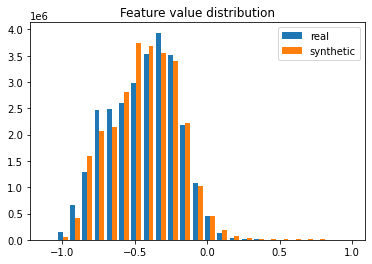

In [26]:
# Compare real and synthetic distribution of page views
plt.hist([wwt_features.flatten(),wwt_synthetic_features1.flatten()], bins=25, label=["real", "synthetic"])

plt.title("Feature value distribution")
plt.legend()
plt.show()


In [15]:
wwt_synthetic_acf1 = get_autocorr(wwt_synthetic_features1)
wwt_acf = get_autocorr(wwt_features)

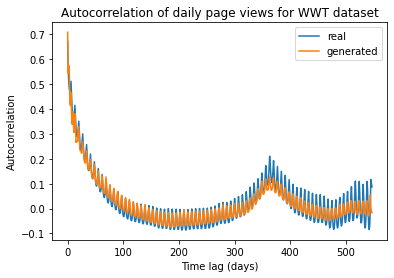

In [16]:
# Figure 1, autocorrelation
plt.plot(wwt_acf, label="real")
plt.plot(wwt_synthetic_acf1, label="generated")
plt.xlabel("Time lag (days)")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation of daily page views for WWT dataset")
plt.legend()
plt.show()



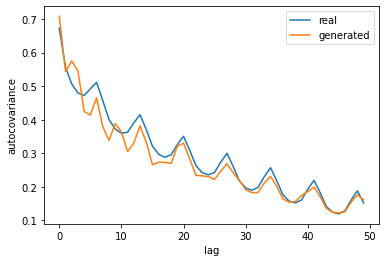

In [17]:
# Zoom in on first 50 day lags of autocorrelation
plt.plot(wwt_acf[0:50], label="real")
plt.plot(wwt_synthetic_acf1[0:50], label="generated")
plt.xlabel("Time lag (days)")
plt.ylabel("Autocorrelation")
plt.legend()
plt.show()

# Original params
Paper uses batch_size=100 which is slower. Also a bit more inconsistent if the training produces a good model than the lower learning rate and larger batch size.

In [18]:
# Train DGAN model

config2 = DGANConfig(
    max_sequence_len=wwt.shape[1] - 3,
    sample_len=10,
    use_attribute_discriminator=True,
    gradient_penalty_coef=10.0,
    attribute_gradient_penalty_coef=10.0,
    generator_learning_rate=1e-3,
    discriminator_learning_rate=1e-3,
    attribute_discriminator_learning_rate=1e-3,
    attribute_loss_coef=1.0,
    apply_feature_scaling=False,  # features are already scaled to [-1,1]
    apply_example_scaling=True,
    normalization=Normalization.MINUSONE_ONE,
    batch_size=100,
    epochs=400,
)

wwt_model2 = DGAN(config=config2)

start_time = time.time()
wwt_model2.train_dataframe(
    df=wwt,
    df_attribute_columns=["domain", "access", "agent"],
    attribute_types=[OutputType.DISCRETE] * 3,
    feature_types=[OutputType.CONTINUOUS],
)

# Generate data

synthetic2 = wwt_model2.generate_dataframe(50000)



end_time = time.time()
print("Elapsed time: {} seconds".format(end_time - start_time))

2022-05-12 17:41:34,676 : MainThread : INFO : epoch: 0
2022-05-12 17:41:49,310 : MainThread : INFO : epoch: 1
2022-05-12 17:42:03,954 : MainThread : INFO : epoch: 2
2022-05-12 17:42:18,644 : MainThread : INFO : epoch: 3
2022-05-12 17:42:33,341 : MainThread : INFO : epoch: 4
2022-05-12 17:42:47,968 : MainThread : INFO : epoch: 5
2022-05-12 17:43:02,405 : MainThread : INFO : epoch: 6
2022-05-12 17:43:16,931 : MainThread : INFO : epoch: 7
2022-05-12 17:43:31,511 : MainThread : INFO : epoch: 8
2022-05-12 17:43:46,197 : MainThread : INFO : epoch: 9
2022-05-12 17:44:00,807 : MainThread : INFO : epoch: 10
2022-05-12 17:44:15,415 : MainThread : INFO : epoch: 11
2022-05-12 17:44:29,985 : MainThread : INFO : epoch: 12
2022-05-12 17:44:44,634 : MainThread : INFO : epoch: 13
2022-05-12 17:44:59,244 : MainThread : INFO : epoch: 14
2022-05-12 17:45:13,942 : MainThread : INFO : epoch: 15
2022-05-12 17:45:28,667 : MainThread : INFO : epoch: 16
2022-05-12 17:45:43,308 : MainThread : INFO : epoch: 17
20

2022-05-12 18:17:19,383 : MainThread : INFO : epoch: 146
2022-05-12 18:17:34,025 : MainThread : INFO : epoch: 147
2022-05-12 18:17:48,756 : MainThread : INFO : epoch: 148
2022-05-12 18:18:03,322 : MainThread : INFO : epoch: 149
2022-05-12 18:18:18,036 : MainThread : INFO : epoch: 150
2022-05-12 18:18:32,774 : MainThread : INFO : epoch: 151
2022-05-12 18:18:47,707 : MainThread : INFO : epoch: 152
2022-05-12 18:19:02,345 : MainThread : INFO : epoch: 153
2022-05-12 18:19:17,130 : MainThread : INFO : epoch: 154
2022-05-12 18:19:31,791 : MainThread : INFO : epoch: 155
2022-05-12 18:19:46,510 : MainThread : INFO : epoch: 156
2022-05-12 18:20:01,153 : MainThread : INFO : epoch: 157
2022-05-12 18:20:15,839 : MainThread : INFO : epoch: 158
2022-05-12 18:20:30,495 : MainThread : INFO : epoch: 159
2022-05-12 18:20:45,298 : MainThread : INFO : epoch: 160
2022-05-12 18:20:59,964 : MainThread : INFO : epoch: 161
2022-05-12 18:21:14,626 : MainThread : INFO : epoch: 162
2022-05-12 18:21:29,322 : MainT

2022-05-12 18:52:37,404 : MainThread : INFO : epoch: 290
2022-05-12 18:52:52,041 : MainThread : INFO : epoch: 291
2022-05-12 18:53:06,686 : MainThread : INFO : epoch: 292
2022-05-12 18:53:21,315 : MainThread : INFO : epoch: 293
2022-05-12 18:53:36,034 : MainThread : INFO : epoch: 294
2022-05-12 18:53:50,620 : MainThread : INFO : epoch: 295
2022-05-12 18:54:05,339 : MainThread : INFO : epoch: 296
2022-05-12 18:54:20,090 : MainThread : INFO : epoch: 297
2022-05-12 18:54:34,836 : MainThread : INFO : epoch: 298
2022-05-12 18:54:49,556 : MainThread : INFO : epoch: 299
2022-05-12 18:55:04,199 : MainThread : INFO : epoch: 300
2022-05-12 18:55:18,979 : MainThread : INFO : epoch: 301
2022-05-12 18:55:33,710 : MainThread : INFO : epoch: 302
2022-05-12 18:55:48,347 : MainThread : INFO : epoch: 303
2022-05-12 18:56:02,986 : MainThread : INFO : epoch: 304
2022-05-12 18:56:17,600 : MainThread : INFO : epoch: 305
2022-05-12 18:56:32,278 : MainThread : INFO : epoch: 306
2022-05-12 18:56:47,014 : MainT

Elapsed time: 5882.686103582382 seconds


In [19]:
synthetic2.head()

,domain,access,agent,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,0.0,2.0,0.0,-0.582247,-0.582235,-0.569686,-0.566318,-0.583856,-0.592209,-0.581430,...,-0.538167,-0.528349,-0.548038,-0.538437,-0.478010,-0.500662,-0.495383,-0.495445,-0.484027,-0.503681
1,2.0,0.0,0.0,-0.758597,-0.753504,-0.748816,-0.766970,-0.771542,-0.778567,-0.770014,...,-0.720588,-0.709005,-0.688232,-0.715420,-0.726384,-0.693817,-0.715056,-0.750703,-0.711256,-0.641719
2,8.0,0.0,0.0,-0.488927,-0.471437,-0.460664,-0.490361,-0.501187,-0.504029,-0.490306,...,-0.413109,-0.476649,-0.474656,-0.410518,-0.390324,-0.370199,-0.410079,-0.457627,-0.482885,-0.452867
3,5.0,1.0,0.0,-0.345896,-0.376387,-0.376087,-0.453110,-0.414182,-0.387170,-0.314032,...,-0.587575,-0.580059,-0.584987,-0.595346,-0.595571,-0.587480,-0.566516,-0.579870,-0.577059,-0.573455
4,4.0,0.0,1.0,-0.881823,-0.840634,-0.851142,-0.813540,-0.836390,-0.865303,-0.871109,...,-0.867495,-0.829001,-0.747649,-0.819318,-0.767692,-0.764722,-0.697819,-0.848453,-0.853487,-0.573830


In [20]:
synthetic2.to_csv("synthetic_pytorch_original.csv")

In [21]:
wwt_synthetic_attributes2 = synthetic2[["domain", "access", "agent"]].to_numpy().astype("int")
print(wwt_synthetic_attributes2.shape)
wwt_synthetic_features2 = np.expand_dims(synthetic2.iloc[:,3:].to_numpy(), axis=-1)
print(wwt_synthetic_features2.shape)

(50000, 3)
(50000, 550, 1)


In [22]:
wwt_synthetic_acf2 = get_autocorr(wwt_synthetic_features2)

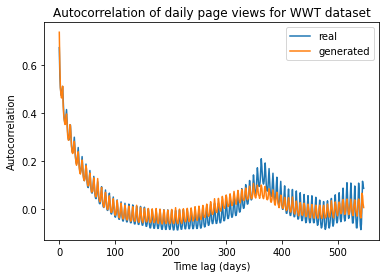

In [23]:
# Figure 1
plt.plot(wwt_acf, label="real")
plt.plot(wwt_synthetic_acf2, label="generated")
plt.xlabel("Time lag (days)")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation of daily page views for WWT dataset")
plt.legend()
plt.show()
